## Kernelized Support Vector Machines

#### *28 October 2019*
#### *DATA 1010*

In [1]:
using LinearAlgebra, Statistics, Distributions, Plots, JuMP, Ipopt, Contour
include("contourplot.jl");

---

## Problem 1

Support vector machines can be used to find nonlinear separating boundaries, because we can map the feature vectors into a higher-dimensional space and use a support vector machine find a separating hyperplane in that space.

Find a map from $\mathbb{R}^2$ to a higher dimensional space such that the two classes shown in the figure can be separated with a hyperplane. 

In [2]:
function randblue()
    t = rand(Uniform(0,2.5))
    (rand(-1:2:1)*cosh(t), rand(-1:2:1)*rand()*sinh(t))
end
function randred()
    t = rand(Uniform(0,2.5))
    (rand(-1:2:1)*cosh(t), rand(-1:2:1)*(0.8+rand()+sinh(t)))
end

randred (generic function with 1 method)

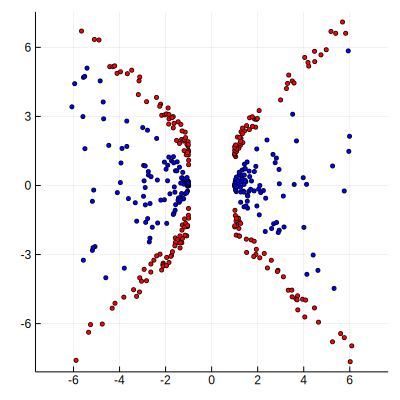

In [3]:
scatter([randblue() for _ in 1:200], legend = false, ratio = 1, ms=2, color = :blue, size = (400,400))
scatter!([randred() for _ in 1:200], ms=2, color = :red)

In [4]:
#heatmap!(-7:0.1:7, -7:0.1:7, (x,y) -> sign(EXPRESSION_HERE), 
#         fillopacity = 0.4, fillcolor = cgrad([:red, :blue]))
#contourplot!(-7:0.1:7, -7:0.1:7, (x,y) -> SAME_EXPRESSION, [0.0], color = :black)

In [ ]:
plotlyjs()
lift(x,y) = (x,y,x^2 - y^2)
scatter([lift(randblue()...) for _ in 1:200], legend = false, ratio = 1, ms=2, color = :blue, fontfamily = "Palatino")
scatter!([lift(randred()...) for _ in 1:200], ms=2, color = :red)

*Solution*. 

---

The key idea that makes the dual formulation of the SVM so useful is that if we apply a transformation $\phi:\mathbb{R}^d \to \mathbb{R}^d$ to each row of $X$ and call the resulting matrix $\phi(X)$, then the resulting change to the dual problem is just to replace $XX'$ with $\phi(X) \phi(X)'$. This matrix's entries consist entirely of dot products of rows of $\phi(X)$ with rows of $\phi(X)$, so we can solve the problem as long as we can calculate $\phi(\mathbf{x})\cdot \phi(\mathbf{y})$ for all $\mathbf{x}$ and $\mathbf{y}$ in $\mathbb{R}^d$. The function $K = (\mathbf{x}, \mathbf{y}) \mapsto \phi(\mathbf{x})\cdot \phi(\mathbf{y})$ is called the *kernel* associated with the transformation $\phi$. Typically we ignore $\phi$ and use one of the following kernel functions:

$$
\begin{align*}
  \text{linear} \quad K(\mathbf{x},\mathbf{y}) &= \mathbf{x}' \mathbf{y} \\
  \text{degree-$d$ polynomial} \quad K(\mathbf{x},\mathbf{y}) &= (\gamma \mathbf{x}' \mathbf{y} + r)^d \\
  \text{Gaussian radial basis function} \quad K(\mathbf{x},\mathbf{y}) &= \exp(-\gamma \|\mathbf{x} - \mathbf{y}\|^2) \\
  \text{sigmoid} \quad K(\mathbf{x},\mathbf{y}) &= \tanh(\gamma \mathbf{x}'\mathbf{y}+ r),
\end{align*}
$$

where $\gamma$ and $r$ are hyperparameters. 

## Problem 2

(a) Complete the code below and train a support vector machine with quadratic kernel ($(\gamma, r) = (1,1)$) on the data given in the first exercise. 

(b) Is this the same as augmenting the feature matrix with quadratic combinations of the original features and then training a linear SVM?

(c) What manipulation of the feature matrix corresponds to setting $r = 0$ in the quadratic kernel?

In [6]:
using JuMP, Ipopt
rbf_kernel(a,b;γ=1) = exp(-γ*sum((a-b).^2));
linear_kernel(a,b) = a ⋅ b
quadratic_kernel(a,b) = (a ⋅ b + 1)^2

mutable struct SVM
    X::Matrix # training features
    y::Vector # training labels
    η::Union{Vector,Missing}
    α::Union{Real,Missing}
    C::Real
    kernel::Function
end

SVM(X,y;η=missing,α=missing,C=1.0,kernel=rbf_kernel) = SVM(X,y,η,α,C,kernel)

function fit!(S::SVM)
    nrows, ncols = size(S.X)
    model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    @variable(model, η[1:nrows])
    @variable(model, α)
    #TODO: define kernel matrix 𝒦 
    #TODO: add objective function and constraints 
    optimize!(model)    
    S.η = value.(η)
    #TODO: define S.α 
    nothing
end

function predict(S::SVM, x)
    #TODO: return prediction vector (don't include signum function)
end

function visualize(S::SVM; signum = true)
    zone(x) = x < -1 ? 1 : (x < 0 ? 2 : (x < 1 ? 3 : 4))
    xmin, xmax = extrema(S.X[:,1])
    ymin, ymax = extrema(S.X[:,2])
    xrange = xmax - xmin
    xmax += 0.25*xrange
    xmin -= 0.25*xrange
    yrange = ymax - ymin
    ymax += 0.25*yrange
    ymin -= 0.25*yrange
    xs = range(xmin, stop = xmax, length=512)
    ys = range(ymin, stop = ymax, length=512)
    Plots.heatmap(xs, ys, (x,y) -> (signum ? zone : identity)(predict(S, [x,y])), 
            fillopacity = 0.5, colorbar = false, fontfamily = "Palatino", 
            fillcolor = cgrad([:blue, :lightblue, :pink, :red]), aspect_ratio = 1, size = (400, 400))
    contourplot!(xs, ys, (x,y) -> predict(S, [x,y]), [-1, 0, 1], color = :black, linewidth = 0.5)
    scatter!(S.X[S.y .== 1, 1], S.X[S.y .== 1, 2], color = :red, label = "", ms = 2, opacity = 0.5)
    scatter!(S.X[S.y .== -1, 1], S.X[S.y .== -1, 2], color = :blue, label = "", ms = 2, opacity = 0.5)
end

visualize (generic function with 1 method)

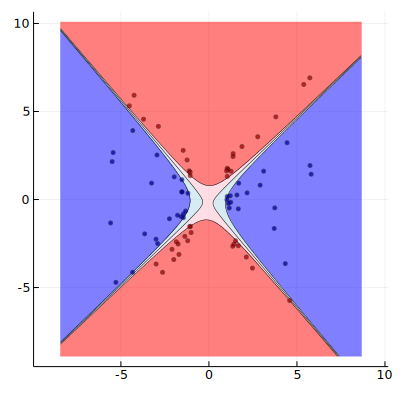

In [7]:
n = 40
X = [vcat([[randblue()...]' for _ in 1:n]...); vcat([[randred()...]' for _ in 1:n]...)]
y = repeat([-1, 1], inner = n);
S = SVM(X, y, kernel = quadratic_kernel, C = 1.0)
fit!(S)
visualize(S)

*Solution*. 

---

## Problem 3

Replace the quadratic kernel with a radial basis kernel (same dataset as above). Experiment with different values of $\gamma$. 

What is the main tradeoff between the RBF and the quadratic kernel?

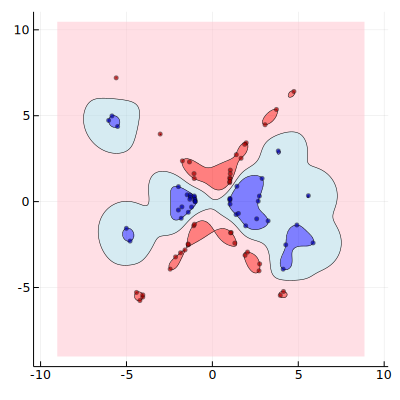

In [8]:
S = SVM(X, y, kernel = (a,b) -> rbf_kernel(a,b,γ=4), C = 10.0)
fit!(S)
visualize(S)

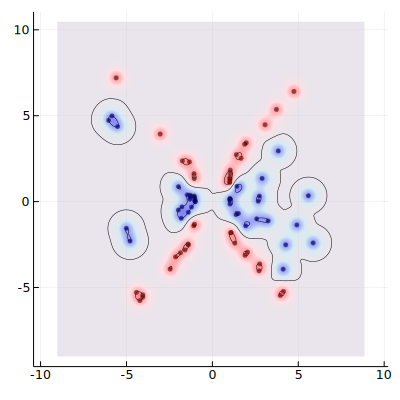

In [9]:
S = SVM(X, y, kernel = (a,b) -> rbf_kernel(a,b,γ=4), C = 10.0)
fit!(S)
visualize(S, signum = false)

*Solution*. 

---

## Problem 4

Explain why plotting the pre-signum predictions for a radial-basis SVM with large $\gamma$ (even like $\gamma \approx 4$) reveals small humps centered at each training point. 

Note: this is a special case of a beautiful result called the *representer theorem*, which has manifestations throughout statistical learning theory.

*Solution*. 

---

## Problem 5 (Challenge)

In class last time, we made the claim that you can recover the value of $\alpha$ in the dual linear soft-margin SVM by looking at training points for which the corresponding component of $\eta$ is strictly between 0 and $C$. In the video, we explained why any such points have to be on the edge of the slab. But is it possible that we would have *no* such points?